In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import arcsin, sqrt
import seaborn as sns
os.chdir("/Users/lgorman/research/phd/farm-size-modelling")

In [97]:
rhomis_data = pd.read_csv("./data/prepped-data/rhomis-ee-gaez.csv")
# rhomis_data["geo_id"] = rhomis_data["ADM0_CODE"] +"_"+ rhomis_data["ADM1_CODE"] +"_"+ rhomis_data["ADM2_CODE"]




land_categories = pd.read_csv("./data/prepped-data/land_cover_classes.csv")


In [99]:
# Convert land cat pixel count to proporiton

land_cat_columns = ["land_cat_"+str(n) for n in range(1, land_categories.shape[0]+1)]

for land_cat_column in land_cat_columns:
    rhomis_data[land_cat_column] = rhomis_data[land_cat_column].fillna(0)
    rhomis_data[land_cat_column]=rhomis_data[land_cat_column]/rhomis_data["pixelCount"]


In [100]:
# Creating a dictionary to switch land category columns
new_col = ["land_cat_"+str(n) for n in range(1, land_categories.shape[0]+1)]
land_categories["colname"]=new_col
land_cat_switch_dict = {}
for i in range(0,land_categories.shape[0]):
    land_cat_switch_dict[land_categories.loc[i, "colname"]]=land_categories.loc[i, "Tag"]




# Dictionary to rename earth engine columns
column_renames_dict = {'accessibility_mean': 'healthcare_traveltime',
        'b1_mean_mean': 'nightlights',
        'population_density_mean_mean': 'population_density',
        'elevation_mean':'elevation',
        'NDVI_mean_mean': 'ndvi',
        'constant_mean': 'topographic_diversity',
        'accessibility_mean': 'healthcare_traveltime',
        'b1_mean_mean': 'nightlights',
        'population_density_mean_mean': 'population_density',
        'elevation_mean': 'elevation',
        'NDVI_mean_mean': 'ndvi',
        'constant_mean': 'topographic_diversity'}
rhomis_data.rename(columns=column_renames_dict,
          inplace=True)
rhomis_data.rename(columns=land_cat_switch_dict,
          inplace=True)


In [101]:
# Removing rows with NA
valid_rows = rhomis_data["land_cultivated_ha"].notna()
# valid_rows = rhomis_data["total_income_ppp_per_year"].notna()

rhomis_data = rhomis_data[valid_rows]

valid_rows = rhomis_data["land_cultivated_ha"]>0
rhomis_data = rhomis_data[valid_rows]

rhomis_data["log_land_cultivated"]=np.log(rhomis_data["land_cultivated_ha"])



In [102]:


aez_cols = list(rhomis_data.columns[rhomis_data.columns.str.contains('AEZ_Classes_', regex=False)])
aez_cols = [ col for col in aez_cols if col !="AEZ_Classes_33"]





In [103]:
# Arcsin transform
rhomis_data[aez_cols]=rhomis_data[aez_cols].apply(sqrt).apply(arcsin)


In [107]:
x_cols = ["healthcare_traveltime",
       "nightlights",
       "population_density",
       "elevation",
       "ndvi",
       "topographic_diversity",
       "adjusted_length_growing_period"]
x_cols.extend(aez_cols)
x_cols.extend(land_categories["Tag"])
x = rhomis_data[x_cols]

y = rhomis_data["log_land_cultivated"]


In [108]:
from sklearn.utils.fixes import sp_version, parse_version

# This is line is
#  to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [109]:
from sklearn.linear_model import QuantileRegressor
# # from sklearn.ensemble import BaggingRegressor

# # quantiles = [0.05,0.1, 0.25,0.5, 0.75,0.95]

# # predictions = {}
# # for quantile in quantiles:
# #     qr = QuantileRegressor(quantile=quantile, alpha=1, solver=solver)
# #     y_pred = qr.fit(x, y).predict(x)
# #     predictions[quantile] = y_pred


# # model = BaggingRegressor(estimator=QuantileRegressor(quantile=0.1, alpha=0, solver=solver)).fit(x, y)
# model =  QuantileRegressor(quantile=0.1, alpha=0.05, solver=solver).fit(x, y)


# Quantile Regression Evaluation

Evaluated using [mean pinball loss](https://scikit-learn.org/stable/modules/model_evaluation.html#pinball-loss)

In [110]:
from sklearn.utils import resample

# quanitle=0.1

n_iterations = 100
n_size = int(y.shape[0] * 0.50)

whole_sample_list = [i for i in range(0,y.shape[0])]

results_frames=[]

for i in range(0,n_iterations):
    for q in [0.05,0.1,0.25,0.5,0.75,0.9,0.95]:

        sub_sample_list = resample(whole_sample_list, n_samples=n_size)

        x_subsample = x.iloc[sub_sample_list,:]
        y_subsample = y.iloc[sub_sample_list]
        
        model =  QuantileRegressor(quantile=q, alpha=0.01, solver=solver).fit(x_subsample, y_subsample)

        run_name = 'run_'+str(i)

        new_result = pd.DataFrame.from_dict({
        run_name : model.coef_
        },columns= model.feature_names_in_,orient='index')

        new_result["quantile"]=q
        results_frames.append(new_result)


result = pd.concat(results_frames)
    # result_0_5 = pd.concat(results_frames_0_5)

non_zero_result = result.columns[(result == 0).all()==False]
result =result[non_zero_result]

melted_result = result.melt(id_vars=["quantile"])
melted_result["log_value"] = np.log(melted_result["value"])
  


/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [115]:
result

,healthcare_traveltime,nightlights,population_density,elevation,ndvi,adjusted_length_growing_period,AEZ_Classes_33_land_with_severe_soil_or_terrain_limitations,AEZ_Classes_33_tropics_highland_humid,AEZ_Classes_33_tropics_highland_semi_arid,AEZ_Classes_33_tropics_highland_sub_humid,AEZ_Classes_33_tropics_lowland_humid,AEZ_Classes_33_tropics_lowland_sub_humid,grass_land,quantile
run_0,0.002616,0.000000,-0.000771,-0.000344,0.000010,-0.002882,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.05
run_0,0.000796,-0.009321,-0.000827,-0.000412,-0.000049,-0.002733,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.10
run_0,0.004786,-0.050366,-0.000190,-0.000522,-0.000110,-0.001842,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.194367,0.25
run_0,0.003909,-0.024228,-0.000387,-0.000456,-0.000074,-0.001399,-0.117894,0.0,0.0,0.037091,0.0,0.000000,0.217392,0.50
run_0,0.003737,-0.010373,-0.000112,-0.000485,-0.000093,-0.002804,-0.216517,0.0,0.0,0.000000,0.0,0.018865,0.000000,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_99,0.005264,-0.073588,-0.000266,-0.000474,-0.000109,-0.001636,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.164766,0.25
run_99,0.004235,-0.048003,-0.000056,-0.000471,-0.000094,-0.001212,-0.148450,0.0,0.0,0.055296,0.0,0.036311,0.256801,0.50
run_99,0.003302,-0.001273,-0.000348,-0.000450,-0.000084,-0.002387,-0.242596,0.0,0.0,0.000000,0.0,0.043150,0.029454,0.75
run_99,0.002765,0.000000,-0.000268,-0.000589,-0.000056,-0.002310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.90


In [117]:
rhomis_data["ndvi"]

0        4912.853535
1        1964.251460
2        4256.294692
3        2715.169396
4        3315.526041
            ...     
20036    6931.871394
20037    4078.523274
20038    4572.833168
20039    5771.468424
20040    5710.293323
Name: ndvi, Length: 19603, dtype: float64

<AxesSubplot: xlabel='quantile', ylabel='ndvi'>

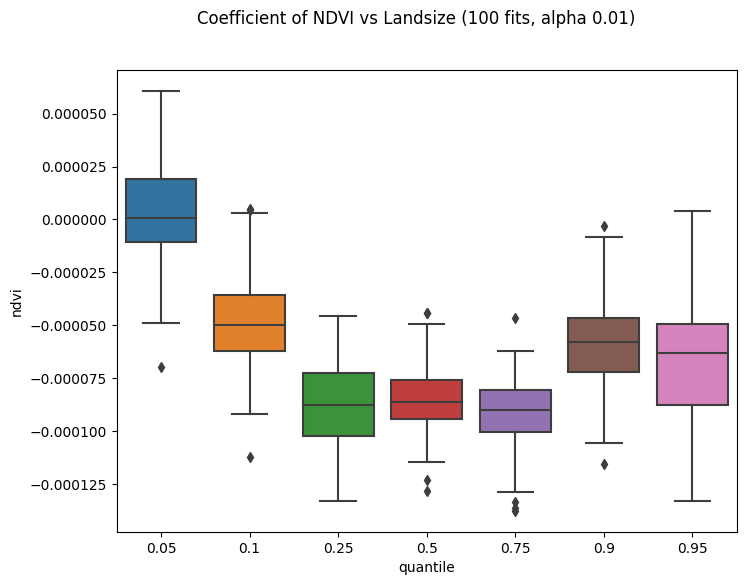

In [116]:

# result
# plt.plot(result["quantile"], result["healthcare_traveltime"])

# plt.plot(result["quantile"], result["healthcare_traveltime"])

# plt.plot(result["quantile"], result["ndvi"])


fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Coefficient of NDVI vs Landsize (100 fits, alpha 0.01)')

sns.boxplot(x="quantile", y="ndvi",
            data=result, ax=ax)

<AxesSubplot: xlabel='quantile', ylabel='population_density'>

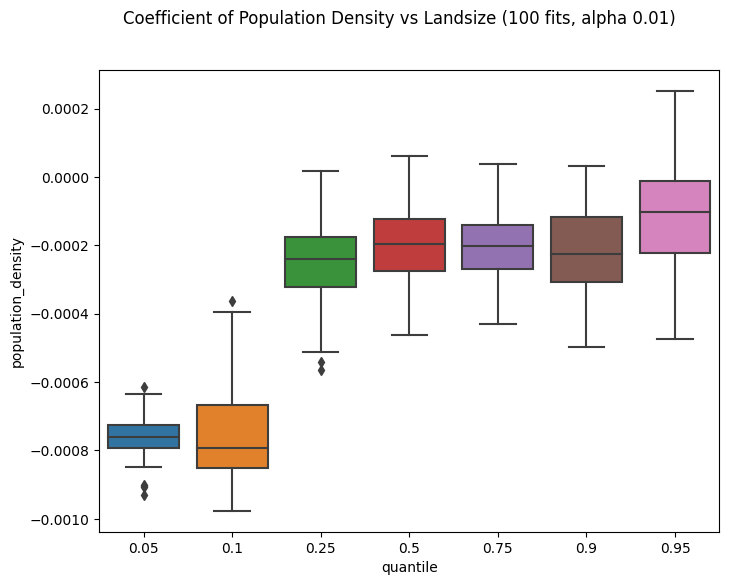

In [119]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Coefficient of Population Density vs Landsize (100 fits, alpha 0.01)')

sns.boxplot(x="quantile", y="population_density",
            data=result, ax=ax)

<AxesSubplot: xlabel='quantile', ylabel='adjusted_length_growing_period'>

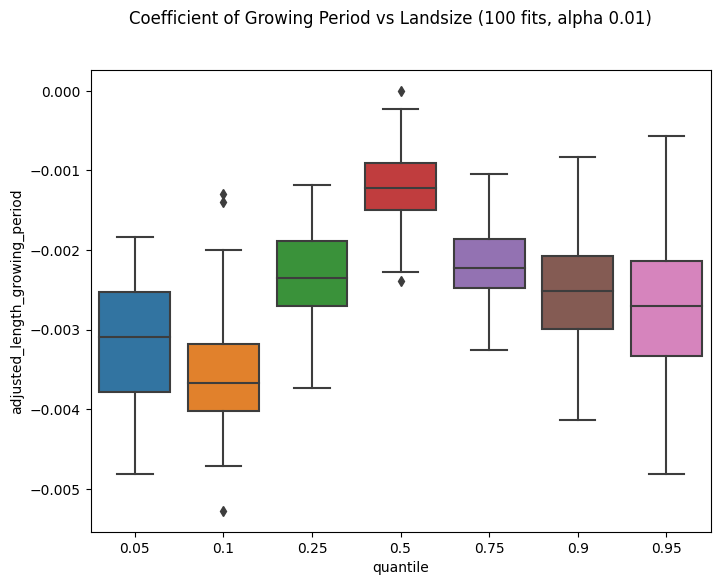

In [121]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Coefficient of Growing Period vs Landsize (100 fits, alpha 0.01)')

sns.boxplot(x="quantile", y="adjusted_length_growing_period",
            data=result, ax=ax)

<AxesSubplot: xlabel='quantile', ylabel='nightlights'>

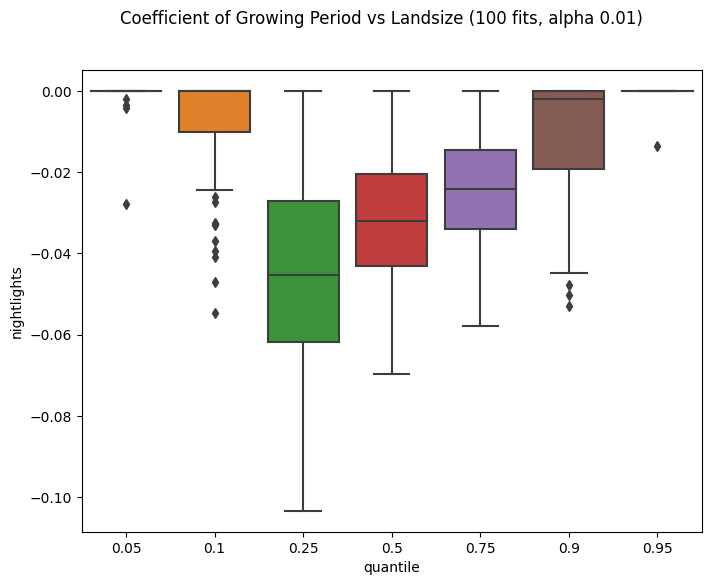

In [120]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Coefficient of Night Lights vs Landsize (100 fits, alpha 0.01)')

sns.boxplot(x="quantile", y="nightlights",
            data=result, ax=ax)

<AxesSubplot: xlabel='quantile', ylabel='healthcare_traveltime'>

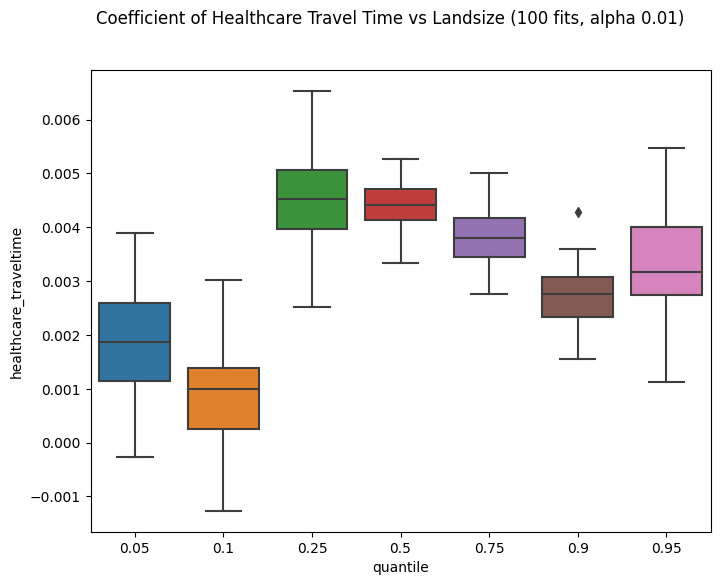

In [122]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Coefficient of Healthcare Travel Time vs Landsize (100 fits, alpha 0.01)')

sns.boxplot(x="quantile", y="healthcare_traveltime",
            data=result, ax=ax)

In [85]:
result

,healthcare_traveltime,nightlights,population_density,elevation,ndvi,adjusted_length_growing_period,AEZ_Classes_33_land_with_severe_soil_or_terrain_limitations,AEZ_Classes_33_tropics_highland_humid,AEZ_Classes_33_tropics_highland_semi_arid,AEZ_Classes_33_tropics_highland_sub_humid,AEZ_Classes_33_tropics_lowland_humid,AEZ_Classes_33_tropics_lowland_semi_arid,AEZ_Classes_33_tropics_lowland_sub_humid,grass_land,cropland,quantile
run_0,0.001111,0.000000,-0.000077,-0.000102,0.000016,-0.001484,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.05
run_0,0.001294,-0.016763,-0.000008,-0.000226,-0.000037,-0.002076,0.000000,0.0,0.000000,0.000000,0.0,0.009979,0.0,0.000000,0.0,0.10
run_0,0.006203,-0.033795,0.000032,-0.000447,-0.000029,-0.002409,-0.013724,0.0,-0.076519,0.000000,0.0,0.026037,0.0,0.175109,0.0,0.25
run_0,0.008083,-0.065278,0.000062,-0.000758,-0.000105,-0.003310,-0.262481,0.0,0.000000,0.028726,0.0,0.000000,0.0,0.533968,0.0,0.50
run_0,0.010510,-0.111257,0.000036,-0.001469,-0.000280,-0.006566,-0.479325,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.248225,0.0,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_99,0.005983,-0.044176,0.000114,-0.000466,-0.000021,-0.002529,0.000000,0.0,-0.084723,0.000000,0.0,0.000000,0.0,0.253771,0.0,0.25
run_99,0.008657,-0.064903,0.000184,-0.000779,-0.000135,-0.003457,-0.219758,0.0,0.000000,0.013674,0.0,0.000000,0.0,0.534651,0.0,0.50
run_99,0.015375,-0.107654,0.000116,-0.001426,-0.000275,-0.007836,-0.641987,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.75
run_99,0.012580,-0.123949,-0.000404,-0.002942,-0.000440,-0.014859,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.90


In [54]:
melted_result = result.melt(id_vars=["quantile"])
melted_result["log_value"] = np.log(melted_result["value"])

/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
melted_result

,quantile,variable,value,log_value
0,0.1,healthcare_traveltime,0.001953,-6.238382
1,0.1,healthcare_traveltime,0.001065,-6.845066
2,0.1,healthcare_traveltime,0.002260,-6.092377
3,0.1,healthcare_traveltime,0.002241,-6.100906
4,0.1,healthcare_traveltime,0.001927,-6.251904
...,...,...,...,...
6795,0.5,water_bodies,0.421202,-0.864643
6796,0.5,water_bodies,4.076407,1.405216
6797,0.5,water_bodies,0.778926,-0.249839
6798,0.5,water_bodies,0.346254,-1.060584


/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/lgorman/research/phd/farm-size-modelling/pyenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<AxesSubplot: xlabel='variable', ylabel='log_value'>

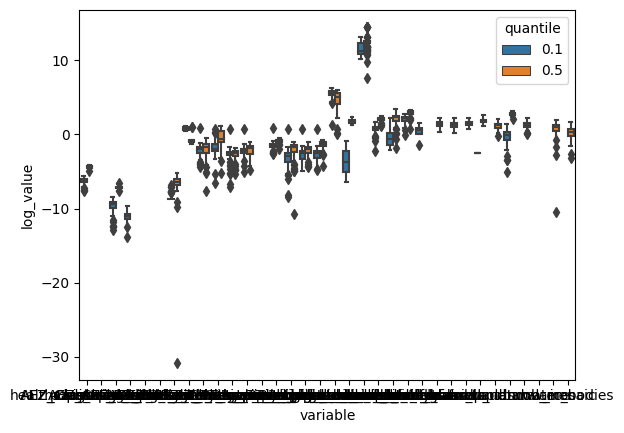

In [57]:
# fig, ax = plt.subplots(figsize=(10,8))
# plt.suptitle('')
# melted_result.boxplot(column=['value'], by='variable', ax=ax)

sns.boxplot(x="variable", hue="quantile", y="log_value", data=melted_result)